## Imports and Data Access

In [1]:
%pip install OpenEnsembles==2.0.0 

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install dython

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import dython
from datetime import datetime as dt
from sklearn.preprocessing import quantile_transform, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.cm as cm
import openensembles as oe

pd.set_option("max_columns", None)
pd.set_option("max_rows", None)

C:\Users\rhian\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Read in the data
df = pd.read_csv("marketing_campaign.csv", "\t")

## Exploratory Analysis

In [6]:
df.shape

(2240, 29)

In [7]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

There are a small number of nulls in the income column (24). I have no way of knowing whether these are customers who have no income or whether the data is missing. For this reason, I will decide not to lose any data, and I will replace the nulls with zeros as this is a valid scenario.


In [8]:
# Check for any NaNs and replace with zeros
df.Income = df.Income.fillna(0)

In [12]:
# Drop Z_CostContact and Z_Revenue as they appear to just be constants
df = df.drop(["Z_CostContact", "Z_Revenue"], axis=1)

## Feature Engineering

In [13]:
# Define the year today
today_year = dt.today().year
today_date = dt.today()

# Create age feature
df['age'] = today_year - df['Year_Birth']

# Create has_child feature
df['has_child'] = np.where(df['Kidhome'] > 0, 1, 0)

# Create a total_spend feature
df['total_spend'] = df['MntWines']+ df['MntFruits']+ df['MntMeatProducts']+ df['MntFishProducts']+ df['MntSweetProducts']+ df['MntGoldProds']

# Create a total_number_purchases feature
df['total_purchases'] = df['NumWebPurchases']+ df['NumCatalogPurchases']+ df['NumStorePurchases']

# Replace number of purchases with fraction of purchases by location and fraction of purchase w/deals
df['purchases_with_deals'] = df["NumDealsPurchases"]/df['total_purchases']
df['web_purchase_fraction'] = df["NumWebPurchases"]/df['total_purchases']
df['catalog_purchase_fraction'] = df["NumCatalogPurchases"]/df['total_purchases']
df['store_purchase_fraction'] = df["NumStorePurchases"]/df['total_purchases']

# Combine the Accepted Promos into a Count
df["promos_accepted"] = df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] + df["AcceptedCmp4"] + df["AcceptedCmp5"] + df["Response"]

# Is it worth grouping marital statuses together? 
df["Marital_Status"] = df["Marital_Status"].replace({'Divorced':'Single', 'Single':'Single', 'Alone':'Single', 'Widow':'Single', 'Absurd':'Single', 'YOLO':'Single','Married':'Married','Together':'Married'})

# Deal with the date of customer's enrolment (create tenure)
today_date = dt.today()
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['tenure'] = (today_date - df['Dt_Customer']).dt.days

# Improve education groupings
df['Education']=df['Education'].replace({'Basic':'Basic','2n Cycle':'Postgrad','Graduation':'Bachelor','Master':'Postgrad','PhD':'Postgrad'})


In [14]:
# Check for any NaNs and replace with zeros
df = df.fillna(0)

In [15]:
# Check for any data quality issues / zero division errors caused above
df.iloc[df.values==np.inf]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,has_child,total_spend,total_purchases,purchases_with_deals,web_purchase_fraction,catalog_purchase_fraction,store_purchase_fraction,promos_accepted,tenure
1245,6862,1971,Bachelor,Single,1730.0,0,0,2014-05-18,65,1,1,3,1,1,1,15,0,0,0,20,0,0,0,0,0,0,0,51,0,8,0,inf,0.0,0.0,0.0,0,2809
1846,9931,1963,Postgrad,Married,4023.0,1,1,2014-06-23,29,5,0,1,1,1,1,15,0,0,0,19,0,0,0,0,0,0,0,59,1,9,0,inf,0.0,0.0,0.0,0,2773


In [16]:
to_drop = df.iloc[df.values==np.inf]
index_to_drop = to_drop.index.tolist()
index_to_drop

[1245, 1846]

In [17]:
## Some data quality issues arise with some of the feature creation above
# NumDealsPurchases = 15 but total_purchases = 0, giving np.inf datatype which cannot be used
# As I believe this to be a data quality issue I will drop these instances
df.drop(index_to_drop, axis=0, inplace=True)
df.iloc[df.values==np.inf]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,has_child,total_spend,total_purchases,purchases_with_deals,web_purchase_fraction,catalog_purchase_fraction,store_purchase_fraction,promos_accepted,tenure


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2238 entries, 0 to 2239
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         2238 non-null   int64         
 1   Year_Birth                 2238 non-null   int64         
 2   Education                  2238 non-null   object        
 3   Marital_Status             2238 non-null   object        
 4   Income                     2238 non-null   float64       
 5   Kidhome                    2238 non-null   int64         
 6   Teenhome                   2238 non-null   int64         
 7   Dt_Customer                2238 non-null   datetime64[ns]
 8   Recency                    2238 non-null   int64         
 9   MntWines                   2238 non-null   int64         
 10  MntFruits                  2238 non-null   int64         
 11  MntMeatProducts            2238 non-null   int64         
 12  MntFis

In [19]:
# Select just relevant colums
df_ID = df['ID']
df = df.drop(["ID", "Year_Birth", "Kidhome", "Teenhome", "Dt_Customer", "MntWines", "MntFruits",
              "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds", "NumDealsPurchases", 
              "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "AcceptedCmp1", "AcceptedCmp2",
              "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"], axis=1)

### Encoding

In [20]:
le = LabelEncoder()
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
for i in cat_cols:
    df[i] = le.fit_transform(df[[i]])

C:\Users\rhian\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [21]:
df

,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Complain,age,has_child,total_spend,total_purchases,purchases_with_deals,web_purchase_fraction,catalog_purchase_fraction,store_purchase_fraction,promos_accepted,tenure
0,0,1,58138.0,58,7,0,65,0,1617,22,0.136364,0.363636,0.454545,0.181818,1,3578
1,0,1,46344.0,38,5,0,68,1,27,4,0.500000,0.250000,0.250000,0.500000,0,2732
2,0,0,71613.0,26,4,0,57,0,776,20,0.050000,0.400000,0.100000,0.500000,0,3079
3,0,0,26646.0,26,6,0,38,1,53,6,0.333333,0.333333,0.000000,0.666667,0,2672
4,2,0,58293.0,94,5,0,41,1,422,14,0.357143,0.357143,0.214286,0.428571,0,2928
5,2,0,62513.0,16,6,0,55,0,716,20,0.100000,0.300000,0.200000,0.500000,0,3060
6,0,1,55635.0,34,6,0,51,0,590,17,0.235294,0.411765,0.176471,0.411765,0,3360
7,2,0,33454.0,32,8,0,37,1,169,8,0.250000,0.500000,0.000000,0.500000,0,3095
8,2,0,30351.0,19,9,0,48,1,46,5,0.200000,0.600000,0.000000,0.400000,1,3155
9,2,0,5648.0,68,20,0,72,1,49,1,1.000000,1.000000,0.000000,0.000000,1,2875


In [22]:
# Re-Run Identification of Binary / Continious Features and Add Categorical to Binary Features
b_feature_names = [col for col in df if df[col].dropna().value_counts().index.isin([0,1]).all()]
cat_feature_names = b_feature_names + ["Education", "Marital_Status"]
c_feature_names = [col for col in df.columns if col not in cat_feature_names]

### Apply Quantile Transformation to Continuous Features

In [23]:
# access continous features
cont_features = df[c_feature_names]

# apply quantile transform
qc_features = pd.DataFrame(
  quantile_transform(cont_features, output_distribution='normal', ignore_implicit_zeros=True),
  columns=cont_features.columns,
  copy=True)

# show transformed data
qc_features

C:\Users\rhian\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_data.py:2503: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"


,Income,Recency,NumWebVisitsMonth,age,total_spend,total_purchases,purchases_with_deals,web_purchase_fraction,catalog_purchase_fraction,store_purchase_fraction,promos_accepted,tenure
0,0.251036,0.243255,0.576075,0.848075,1.404533,1.189522,-0.385726,0.307111,1.902873,-2.408550,0.880888,1.994971
1,-0.170185,-0.278302,-0.213636,1.118711,-1.479004,-1.239352,1.280981,-0.645631,0.662724,0.018820,-5.199338,-1.733071
2,0.839048,-0.615025,-0.514923,0.338834,0.374690,0.873515,-1.210137,0.562796,-0.387078,0.018820,-5.199338,-0.149853
3,-1.102325,-0.615025,0.135911,-1.242061,-0.890172,-0.595437,0.543789,0.064027,-5.199338,1.102440,-5.199338,-1.918441
4,0.255429,1.629992,-0.213636,-0.981540,0.043068,0.156199,0.700711,0.265284,0.403356,-0.545244,-5.199338,-0.728240
5,0.410059,-0.953493,0.135911,0.212353,0.318693,0.873515,-0.562796,-0.190587,0.312376,0.018820,-5.199338,-0.212353
6,0.160942,-0.377630,0.135911,-0.085414,0.216269,0.482248,0.080379,0.702315,0.191865,-0.641002,-5.199338,0.969427
7,-0.748979,-0.425228,1.186981,-1.331018,-0.304482,-0.287442,0.193143,1.407905,-5.199338,0.018820,-5.199338,-0.091712
8,-0.914679,-0.848075,1.994971,-0.350817,-1.008294,-0.868016,-0.037646,2.345158,-5.199338,-0.724973,0.880888,0.119468
9,-2.229015,0.489307,5.199338,1.593219,-0.939747,-2.747453,3.094018,5.199338,-5.199338,-5.199338,0.880888,-0.927897


In [24]:
qc_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2238 entries, 0 to 2237
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Income                     2238 non-null   float64
 1   Recency                    2238 non-null   float64
 2   NumWebVisitsMonth          2238 non-null   float64
 3   age                        2238 non-null   float64
 4   total_spend                2238 non-null   float64
 5   total_purchases            2238 non-null   float64
 6   purchases_with_deals       2238 non-null   float64
 7   web_purchase_fraction      2238 non-null   float64
 8   catalog_purchase_fraction  2238 non-null   float64
 9   store_purchase_fraction    2238 non-null   float64
 10  promos_accepted            2238 non-null   float64
 11  tenure                     2238 non-null   float64
dtypes: float64(12)
memory usage: 209.9 KB


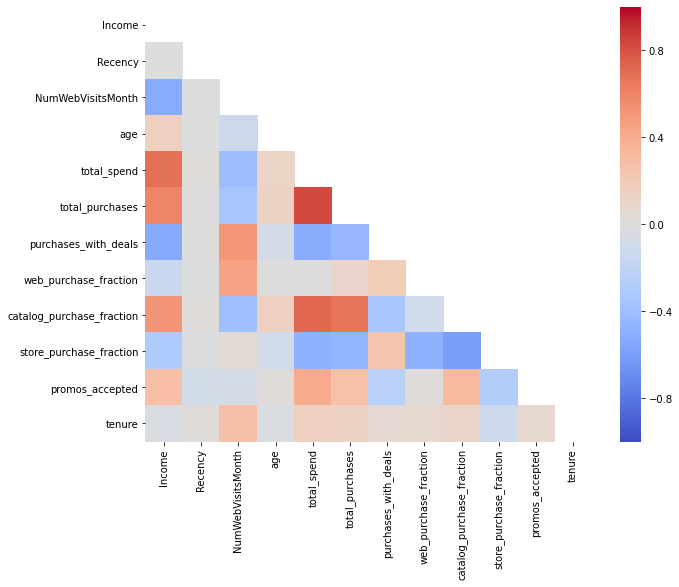

In [25]:
# Get correlation matrix
qc_features_corr = qc_features.corr() 

# use a mask to remove top-half of heatmap
top_mask = np.zeros(qc_features_corr.shape, dtype=bool)
top_mask[np.triu_indices(len(top_mask))] = True

plt.figure(figsize=(10,8))

# Plot heatmap
hmap = sns.heatmap(
  qc_features_corr,
  cmap = 'coolwarm',
  vmin =  1.0, 
  vmax = -1.0,
  mask = top_mask
  )

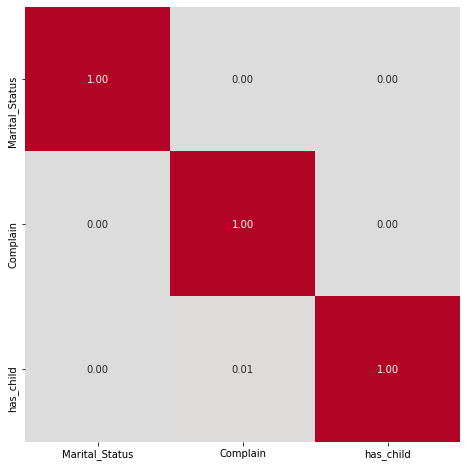

In [26]:
# Look at correlations between binary variables with Theil's U

_ = dython.nominal.associations(
  df[b_feature_names], 
  nominal_columns='all',
  nom_nom_assoc='theil',
  figsize=(10,8),
  cmap='coolwarm',
  vmax=1.0,
  vmin=0.0,
  cbar=False
  )

## Apply Dimensionality Reduction

In [27]:
variance_ratio = {}

for i in range(1, len(qc_features.columns)+1):
    pca = PCA(n_components=i)
    pca.fit(qc_features)
    variance_ratio[f'n_{i}'] = pca.explained_variance_ratio_.sum()
    
variance_ratio

{'n_1': 0.4426537121630593,
 'n_2': 0.6557390202663247,
 'n_3': 0.7469770345793523,
 'n_4': 0.8045126253547384,
 'n_5': 0.8559998828232677,
 'n_6': 0.8959692768700654,
 'n_7': 0.9322780759915021,
 'n_8': 0.9565379212353478,
 'n_9': 0.972716914685701,
 'n_10': 0.9860968061023079,
 'n_11': 0.9947050697560279,
 'n_12': 0.9999999999999999}

It seems reasonable to keep 80% of the variance and use 4 principal components. 

In [28]:
pca = PCA(n_components =4, random_state = 42)

pca.fit(qc_features)
data_pca = pd.DataFrame(pca.transform(qc_features), 
                        columns = (["PC1", "PC2", "PC3", "PC4"]))

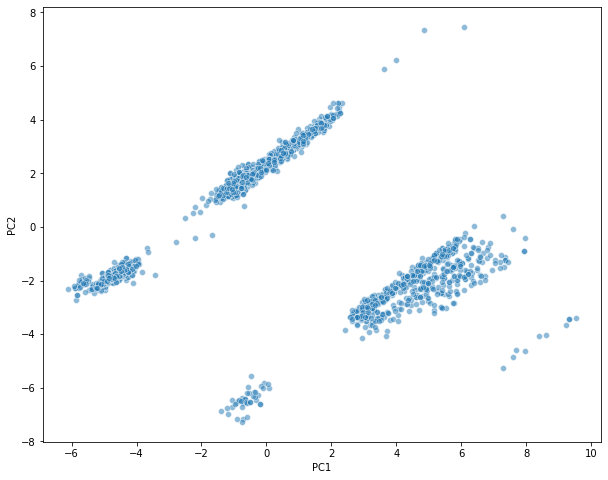

In [29]:
fig, ax = plt.subplots(figsize=(10,8))

_ = sns.scatterplot(
  data=data_pca,
  x='PC1',
  y='PC2',
  alpha=0.5,
  ax=ax
  )

## Cluster Ensembles

In [30]:
d = oe.data(data_pca, [1,2,3,4])

#plt_data = d.plot_data('parent')

c  = oe.cluster(d) #instantiate an object so we can get all available algorithms
a = c.algorithms_available()
paramsC = c.clustering_algorithm_parameters() #here we will rely on walking through

# remove DBSCAN -- this does very well on unstructured data, we want to ask if we can use poorly performing algorithms
# to identify if there isn't structure.
algorithmsToRemove = ['DBSCAN', 'HDBSCAN', 'MeanShift', 'Birch']
for algToRemove in algorithmsToRemove:
    del a[algToRemove]

takesLinkages = paramsC['linkage']
takesDistances = paramsC['distance']
takesK = paramsC['K']

In [31]:
#setup the parameters of clustering here, algorithms are set by algorithms_available
K = range(2,9)
linkages = ['average', 'ward']
distances = ['euclidean', 'l1', 'l2']

In [32]:
# Create an ensemble: sweep K, distance metrics
c = oe.cluster(d)
for data_source in d.D.keys(): #if there were transformations in d.D
    for algorithm in list(a.keys()): #linkage is only for agglomerative, which also accepts K and distances, so handle that here
        if algorithm in takesK:
            for k in K:
                if algorithm in takesDistances:
                    if algorithm in takesLinkages:
                        for linkage in linkages:
                            if linkage == 'ward':
                                out_name = '_'.join([data_source, algorithm, linkage, str(k)])
                                c.cluster(data_source, algorithm, out_name, K=k, Require_Unique= True, linkage=linkage)
                            else:
                                for dist in distances:
                                    out_name = '_'.join([data_source, algorithm, dist, linkage, str(k)])
                                    c.cluster(data_source, algorithm, out_name, K=k, Require_Unique= True, linkage=linkage, distance=dist)



                    else:
                        for dist in distances:
                            out_name = '_'.join([data_source, algorithm, dist, str(k)])
                            c.cluster(data_source, algorithm, out_name, K=k, Require_Unique= True, distance=dist)
                else:
                    out_name = '_'.join([data_source, algorithm, str(k)])
                    c.cluster(data_source, algorithm, out_name, K=k, Require_Unique= True)


        else: # does not take K
            if algorithm in takesDistances:
                    for dist in distances:
                        out_name = '_'.join([data_source, algorithm, dist])
                        c.cluster(data_source, algorithm, out_name, Require_Unique= True, distance=dist)
            else:
                out_name = '_'.join([data_source, algorithm])
                c.cluster(data_source, algorithm, out_name, Require_Unique= True)

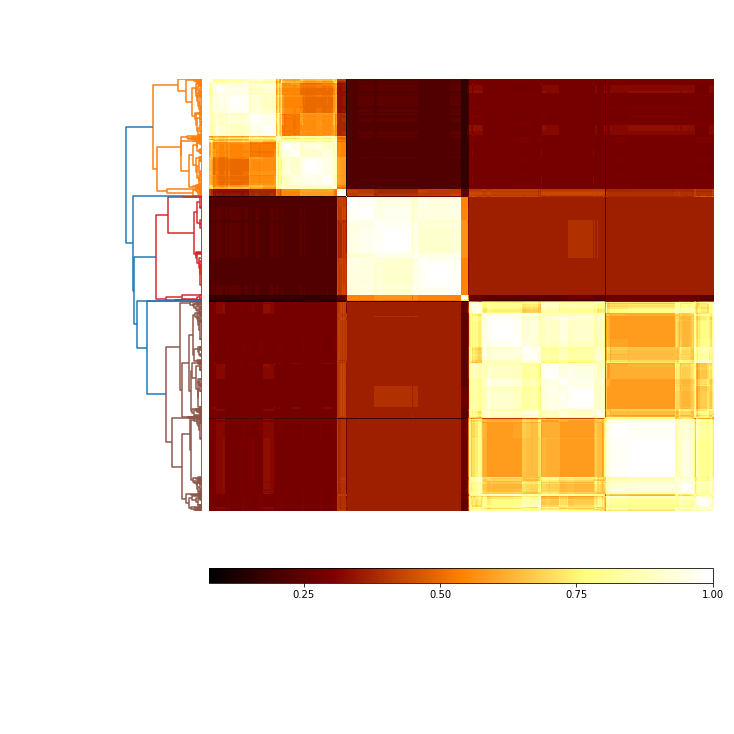

In [33]:
#View the ensembles
coMat = c.co_occurrence_matrix()

fig = coMat.plot(add_labels=False)


In [34]:
# Explore effects of threshold on graph closure
thresholds = [0.5, 0.7]
fig = 0
c_graph_dict = {}
c_majority_vote_dict = {}
for threshold in thresholds:
    c_graph = c.finish_graph_closure(threshold=threshold)
    c_graph_dict[str(threshold)] = c_graph
    c_majority_vote = c.finish_majority_vote(threshold=threshold)
    c_majority_vote_dict[str(threshold)] = c_majority_vote



MemoryError: 